![Logo de AA1](logo_AA1_texto_small.png) 
# Sesión 17 - Boosting

Ya introdujimos en la anterior sesión los *ensembles* (https://en.wikipedia.org/wiki/Ensemble_learning), que son métodos que utilizan varios modelos para obtener un modelo más poderoso.

Dos métodos de ensembles han destacado por su buen rendimiento:
- Bagging y
- Boosting

En la anterior sesión nos centramos en el Bagging y en esta sesión nos centraremos en el **Boosting**.

En el boosting se utilizan modelos muy simples (*clasificadores débiles*) para combinarlos y obtener un clasificador fuerte. Como clasificadores débiles es muy común utilizar árboles de decisión con `max_depth=1`, con lo que es evidente que se trata de clasificadores débiles.

En boosting se utilizan todos los ejemplos disponibles para entrenar (no como en bagging donde se hacían muestreos con reemplazamiento). La particularidad que tiene el boosting es que tras entrenar el primer modelo se utilizará el mismo para clasificar los ejemplos del conjunto de entrenamiento. Como es un clasificador débil (muy limitado) algunos ejemplos los acertará y otros los fallará, así que se asignarán pesos a los ejemplos: mayor peso a los fallados y menor peso a los acertados. Se entrenará un nuevo modelo que se utilizará para volver a clasificar los ejemplos y que dará lugar a una nueva asignación de pesos. Este proceso se repetirá las veces que queramos:

![boosting](fig_boosting.png) 

Es importante darse cuenta de que **en boosting los modelos deben entrenarse de manera secuencial**: no se puede entrenar el modelo i-ésimo hasta que se tengan los pesos resultantes del modelo (i-1)-ésimo.

Una vez entrenados todos los modelos débiles podremos calcular la predicción de un nuevo ejemplo mediante una media ponderada (o una votación) de todos los modelos implicados en el boosting.

Como podemos observar, cada clasificador débil trata de acertar ejemplos que el modelo anterior ha fallado, con lo que **el boosting busca reducir la varianza a la vez que trata de reducir el sesgo** utilizando clasificadores débiles.

Vamos a cargar un conjunto de datos para poder ir haciendo pruebas.

In [1]:
from pydoc import describe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, impute
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# se llama a la función read_csv
# no tiene missing y las columnas están separadas por ','
# tampoco cabecera, así que hay que dar nombre a las columnas (consultamos el .names)
cabecera = ['Age','Gender','TB','DB','inv-nodAlkphos','Sgpt', 'Sgot', 'TP', 'ALB', 'A/G', 'Selector (class)']
df = pd.read_csv('ILPD.data', names=cabecera)
filas, columnas = df.shape

# la clase está en la última columna 
# separamos los atributos y los almacenamos en X
X = df.drop(['Selector (class)'], axis=1)
display(X)

# separamos la clase y la almacenamos en Y
y = df['Selector (class)']
display(y)

,Age,Gender,TB,DB,inv-nodAlkphos,Sgpt,Sgot,TP,ALB,A/G
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40
...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10
580,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00


0      1
1      1
2      1
3      1
4      1
      ..
578    0
579    1
580    1
581    1
582    0
Name: Selector (class), Length: 583, dtype: int64

Una vez cargado el conjunto vamos a dividir el conjunto de ejemplos en entrenamiento y test. 

También debemos preprocesar los atributos de manera conveniente. En este caso tenemos que el atributo "Gender" viene indicado en modo texto ("Male" y "Female") y por tanto debemos transformarlo. En este caso no pasaría nada si realizamos la transformación leyendo los posibles valores sobre todo el conjunto de datos, pero la manera correcta de hacerlo es la siguiente:
- realizaremos el `fit()` sobre los datos del conjunto de entrenamiento. Esto es así puesto que el conjunto de test debemos reservarlo para la evaluación: no debemos utilizarlo en nada que pueda afectar al entrenamiento.
- y haremos el `transform()` sobre los datos que queramos transformar, que serán los de entrenamiento y los de test.

Se haría de la siguiente manera: 

In [2]:
print('\n##########################################')
print('### Hold-out 70-30')
print('##########################################')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)

print('\n##########################################')
print("ANTES de codificar 'Gender'")
print("## Train:")
display(X_train.head(2))
print("## Test:")
display(X_test.head(2))

# se crea el objeto LabelEncoder y se transforma el atributo 'Gender'
lb_enc = LabelEncoder()

# se entrena con los datos de TRAIN
lb_enc.fit(X_train['Gender'])

# se transforma 'Gender' en train y test con el modelo entrenado en TRAIN
X_train['Gender'] = lb_enc.transform(X_train['Gender'])
X_test['Gender'] = lb_enc.transform(X_test['Gender'])

print('\n##########################################')
print("DESPUÉS de codificar 'Gender'")
print("## Train:")
display(X_train.head(2))
print("## Test:")
display(X_test.head(2))



##########################################
### Hold-out 70-30
##########################################

##########################################
ANTES de codificar 'Gender'
## Train:


,Age,Gender,TB,DB,inv-nodAlkphos,Sgpt,Sgot,TP,ALB,A/G
570,16,Male,2.6,1.2,236,131,90,5.4,2.6,0.9
99,18,Male,0.7,0.1,312,308,405,6.9,3.7,1.1


## Test:


,Age,Gender,TB,DB,inv-nodAlkphos,Sgpt,Sgot,TP,ALB,A/G
131,70,Female,0.7,0.2,237,18,28,5.8,2.5,0.75
347,38,Male,0.7,0.2,216,349,105,7.0,3.5,1.00



##########################################
DESPUÉS de codificar 'Gender'
## Train:


,Age,Gender,TB,DB,inv-nodAlkphos,Sgpt,Sgot,TP,ALB,A/G
570,16,1,2.6,1.2,236,131,90,5.4,2.6,0.9
99,18,1,0.7,0.1,312,308,405,6.9,3.7,1.1


## Test:


,Age,Gender,TB,DB,inv-nodAlkphos,Sgpt,Sgot,TP,ALB,A/G
131,70,0,0.7,0.2,237,18,28,5.8,2.5,0.75
347,38,1,0.7,0.2,216,349,105,7.0,3.5,1.00


Este conjunto también tiene valores desconocidos en la columna 'A/G', así que para sustituirlos por valores que podamos procesar vamos a utilizar `KNNImputer` y debemos hacerlo de la misma manera:
- realizaremos `fit()` sobre los datos de entrenamiento
- aplicaremos `transform()` sobre todos los datos

Veamos cómo:

In [3]:
missing_train = X_train['A/G'].isnull()
missing_test = X_test['A/G'].isnull()

print('\n##########################################')
print("ANTES de imputar valores")
print("## Train:")
display(X_train[missing_train])
print("## Test:")
display(X_test[missing_test])

# se creal el KNNImputer para asignar valores
imputer_knn = impute.KNNImputer(n_neighbors=2)

# se entrena sobre el conjunto de TRAIN
imputer_knn.fit(X_train)

# se imputan valores en train y test con el modelo entrenado en TRAIN
X_train[X.columns] = imputer_knn.transform(X_train)
X_test[X.columns] = imputer_knn.transform(X_test)

print('\n##########################################')
print("Después de imputar valores")
print("## Train:")
display(X_train[missing_train])
print("## Test:")
display(X_test[missing_test])



##########################################
ANTES de imputar valores
## Train:


,Age,Gender,TB,DB,inv-nodAlkphos,Sgpt,Sgot,TP,ALB,A/G
253,35,0,0.6,0.2,180,12,15,5.2,2.7,NaN
312,27,1,1.3,0.6,106,25,54,8.5,4.8,NaN
209,45,0,0.9,0.3,189,23,33,6.6,3.9,NaN


## Test:


,Age,Gender,TB,DB,inv-nodAlkphos,Sgpt,Sgot,TP,ALB,A/G
241,51,1,0.8,0.2,230,24,46,6.5,3.1,NaN



##########################################
Después de imputar valores
## Train:


,Age,Gender,TB,DB,inv-nodAlkphos,Sgpt,Sgot,TP,ALB,A/G
253,35.0,0.0,0.6,0.2,180.0,12.0,15.0,5.2,2.7,1.0
312,27.0,1.0,1.3,0.6,106.0,25.0,54.0,8.5,4.8,1.0
209,45.0,0.0,0.9,0.3,189.0,23.0,33.0,6.6,3.9,1.0


## Test:


,Age,Gender,TB,DB,inv-nodAlkphos,Sgpt,Sgot,TP,ALB,A/G
241,51.0,1.0,0.8,0.2,230.0,24.0,46.0,6.5,3.1,0.7


En una sesión práctica a final de curso veremos cómo realizar estas y otras transformaciones de los datos correctamente de manera encadenada y sobre diferentes tipos de atributos. 

Una vez que hemos cargado el conjunto de datos y que lo hemos preprocesado, vamos a evaluar el rendimiento de un árbol de decisión y de un Random Forest (bagging) sobre el conjunto de test y en la siguiente sección emplearemos un algoritmo clásico de boosting:

In [4]:
# árbol de decisión 
sys_dt = DecisionTreeClassifier(random_state=1234)
sys_dt.fit(X_train, y_train) 
y_pred = sys_dt.predict(X_test)
print("Árbol de decisión - Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# random forest (bagging)
sys_rf = RandomForestClassifier(random_state=1234, n_jobs=-1)
sys_rf.fit(X_train, y_train) 
y_pred = sys_rf.predict(X_test)
print("RandomForest   -    Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

Árbol de decisión - Accuracy: 0.6571
RandomForest   -    Accuracy: 0.7086


# 17.1 AdaBoost

Vamos ahora a entrenar un algoritmo de boosting, concretamente el *AdaBoost* (Adaptative Boosting), uno de los algoritmos más famosos en aprendizaje automático.

Para utilizarlo, vamos a crear una instancia de `AdaBoostClassifier`:

In [5]:
# boosting
sys_boos_dt = AdaBoostClassifier()
sys_boos_dt.fit(X_train, y_train) 
y_pred = sys_boos_dt.predict(X_test)
print("Boosting(árbol)   -    Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

Boosting(árbol)   -    Accuracy: 0.7257


Vemos que la accuracy mejora un poco pero no tiene por qué ser siempre así. AdaBoost o distintas versiones de boosting son frecuentemente los ganadores en las competiciones de machine learning y son ampliamente utilizados en la industria.

Hay varios hiperparámetros sobre los que se puede actuar, pudiendo destacarse:
- `base_estimator`, el algoritmo base que utilizaremos (que por defecto es un árbol de decisión con profundidad 1)
- `n_estimators`, número de modelos que se entrenarán
- `learning_rate`, valor en el rango (0, inf) que sirve para indicar con cuánta intensidad intentará  corregir cada árbol los errores de los árboles anteriores. Valores pequeños harán que los pesos sean menos agresivos.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

Vamos a ver cómo afecta el `learning_rate` al rendimiento del AdaBoost:

#### LR: 0.001
#### LR: 0.01
#### LR: 0.1
#### LR: 1
#### LR: 10
#### LR: 20


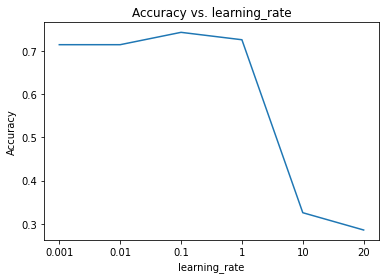

In [6]:
val_lr = [0.001, 0.01, 0.1, 1, 10, 20]  # vamos a probar varios valores de learning_rate

# almacenamos todos los resultados en un vector
scores = np.zeros(len(val_lr), dtype=np.float32)

idx_lr = 0
for lr in val_lr:
    print("#### LR:", lr)
    sys_boos_dt.set_params(learning_rate=lr)   # cambiamos el learning rate
    sys_boos_dt.fit(X_train, y_train)         # entrenamos
    y_pred = sys_boos_dt.predict(X_test)      # evaluamos
    scores[idx_lr] = metrics.accuracy_score(y_test, y_pred)
    idx_lr = idx_lr + 1

lrs = [str(p) for p in val_lr]      # creo los ticks del eje x

fig, ax = plt.subplots()
ax.plot(lrs, scores)
ax.set_title('Accuracy vs. learning_rate')
ax.set_xlabel('learning_rate')
ax.set_ylabel('Accuracy')
plt.show()

En este caso vemos que poner valores muy altos provoca que el rendimiento se vea reducido, pero no siempre tiene por qué ser así.

### 17.1.1 Relevancia de los atributos

Al igual que con el RandomForest, también se puede obtener la relevancia de los atributos:

Boosting(árbol)   -    Accuracy: 0.7429

##########################################
### Relevancia con AdaBoost
##########################################


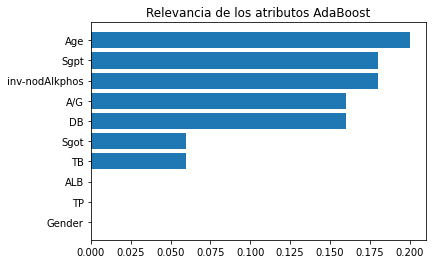


##########################################
### Relevancia con RandomForest
##########################################


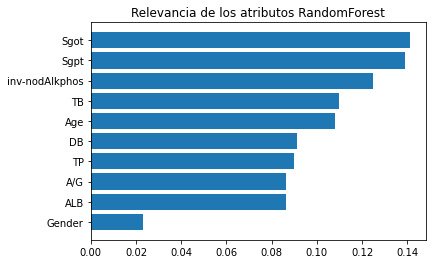

In [7]:
# entrenamos de nuevo el AdaBoost
sys_boos_dt = AdaBoostClassifier(learning_rate=0.1)
sys_boos_dt.fit(X_train, y_train) 
y_pred = sys_boos_dt.predict(X_test)
print("Boosting(árbol)   -    Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# obtenemos el número de atributos
(num_ejemplos, num_atributos) = X.shape 

print('\n##########################################')
print('### Relevancia con AdaBoost')
print('##########################################')

importances = sys_boos_dt.feature_importances_
# ordenamos los atributos en orden descendente de importancia
indices = np.argsort(importances)[::-1]

# los representamos gráficamente
fig, ax = plt.subplots()
ax.set_title("Relevancia de los atributos AdaBoost") 
# [::-1] para que aparezcan en orden decreciente en la gráfica
ax.barh(range(num_atributos), importances[indices[::-1]], tick_label=X.columns[indices[::-1]]) 
plt.show()

print('\n##########################################')
print('### Relevancia con RandomForest')
print('##########################################')

importances = sys_rf.feature_importances_
# ordenamos los atributos en orden descendente de importancia
indices = np.argsort(importances)[::-1]

# los representamos gráficamente
fig, ax = plt.subplots()
ax.set_title("Relevancia de los atributos RandomForest") 
# [::-1] para que aparezcan en orden decreciente en la gráfica
ax.barh(range(num_atributos), importances[indices[::-1]], tick_label=X.columns[indices[::-1]]) 
plt.show()

En este caso vemos que el AdaBoost es más agresivo a la hora de descartar atributos. El hecho de que se utilicen árboles con muy poca profundidad hace que algunos atributos nunca aparezcan en los árboles y por tanto su peso sea nulo.

## 17.2 XGBoost

Hay un algoritmo de boosting muy popular por sus buenos rendimientos y por ser capaz de trabajar con conjuntos de datos muy grandes. Se trata del XGBoost: https://xgboost.readthedocs.io/en/latest/index.html 

No pretendemos explicar sus particularidades, simplemente queremos que sepáis de su existencia.

Para poder utilizarlo es necesario importar la clase `XGBClassifier` de la librería `xgboost`:

In [8]:
from xgboost import XGBClassifier

# boosting
sys_xgb = XGBClassifier()
sys_xgb.fit(X_train, y_train) 
y_pred = sys_xgb.predict(X_test)
print("XGBoost   -    Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

ModuleNotFoundError: No module named 'xgboost'

Vemos que en este caso no mejora los resultados que teníamos.

En https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn podéis ver todos los hiperparámetros de que dispone.

## Ejercicios

1. Carga el fichero **biodeg.data** (es un archivo de texto). 
2. Separa el conjunto en un 70% para entrenar y un 30% para test
3. Obten resultados utilizando árboles de decisión, bagging y boosting
4. Representa la relevancia de los atributos y la incidencia del learning rate en los modelos
5. Repite lo mismo con el conjunto **ionosphere.data**

Estos ejercicios no es necesario entregarlos